# The $z$-transform

This notebook shows some techniques for dealing with discrete systems analytically using the $z$ transform

In [1]:
import sympy
sympy.init_printing()

In [2]:
import tbcontrol
tbcontrol.expectversion('0.1.2')

In [3]:
s, z, q = sympy.symbols('s, z, q')
k = sympy.Symbol('k', integer=True)
Dt = sympy.Symbol('\Delta t', positive=True)

## Definition
The $z$ transform of a sampled signal ($f^*(t)$) is defined as follows:

$$\mathcal{Z}[f^*(t)] = \sum_{k=0}^{\infty} f(k \Delta t) z^{-k}$$

**Note** The notation is often abused, so you may also encounter 
* $\mathcal{Z}[f(t)]$, which should be interpreted as having the sampling implied
* $\mathcal{Z}[F(s)]$, which implies that you should first calculate the inverse Laplace and then sample, so something like $\mathcal{Z}[F(s)]=\mathcal{Z}[\mathcal{L}^{-1}[F(s)]]=\mathcal{Z}[f(t)]$

## Direct calculation in SymPy

For a unit step, $f(t)=1$ and we can obtain the $z$ transform as an infinte series as follows:

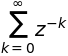

In [4]:
unitstep = sympy.Sum(1/z**k, (k, 0, sympy.oo))
unitstep

Sympy can recognise this infinite series as a geometric series, and under certain conditions for convergence, it can find a finite representation:

In [5]:
shortform = unitstep.doit()
shortform

⎧    1          │1│    
⎪  ─────    for │─│ < 1
⎪      1        │z│    
⎪  1 - ─               
⎪      z               
⎪                      
⎪  ∞                   
⎨ ___                  
⎪ ╲                    
⎪  ╲    -k             
⎪  ╱   z     otherwise 
⎪ ╱                    
⎪ ‾‾‾                  
⎪k = 0                 
⎩                      

To extract the first case solution, we use `args`:

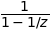

In [6]:
uz = shortform.args[0][0]
uz

Notice what has happened here: we have taken the infinite series and written it in a compact form. You should always keep in mind that these two forms are equivalent.

## Transfer functions from difference equations
For a first order difference equation (the discrete equivalent of a first order differential equation):

$$ y(k) + a_1 y(k - 1) = b_1 u(k - 1) $$

If we interpret $z^{-n}$ as an $n$ time step delay, can write 

$$\mathcal{Z}[y(k - n)] = Y(z)z^{-n}$$ 

This transforms our difference equation to 

$$Y(z) + a_1 z^{-1} Y(z) = b_1 z^{-1} U(z)$$

Leading to a discrete transfer function:

$$G(z) = \frac{Y(z)}{U(z)} = \frac{b_1 z^{-1}}{1 + a_1 z^{-1}}$$

Unfortunately, sympy simplifies this expression using positive powers of $z$

In [7]:
a1, b1 = sympy.symbols('a1, b1')

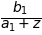

In [8]:
Gz = b1*z**-1/(1 + a1*z**-1)
Gz.cancel()

Since I have not found an easy way to get sympy to report negative powers of $z$, I find it convenient to define

$$q = z^{-1}$$

In [9]:
def qsubs(fz):
    return fz.subs({z: q**-1})

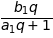

In [10]:
qsubs(Gz)

## Responses and inversion

To find the response of this system to the unit input, we can multiply the input and the transfer function. Note that this is equivalent to convolution of the polinomial coefficients.

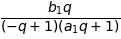

In [11]:
yz = Gz*uz
qsubs(yz)

Let's evaluate that with numeric values for the coefficients:

In [12]:
K = 2 # The worked version in the textbook uses 2 even though the text says 20
tau = 1

In [13]:
Dt = 1

In [14]:
parameters = {a1: -sympy.exp(-Dt/tau),
              b1: K*(1 -  sympy.exp(-Dt/tau))
             }
stepresponse = yz.subs(parameters)

Remember that the $z$ transform was defined using the values of the sampled signal at the sampling points. 

$$\mathcal{Z}[f^*(t)] = \sum_{k=0}^{\infty} f(k \Delta t) z^{-k} = f(0) + f(\Delta t)z^{-1} + f(2\Delta t)z^{-2} + \cdots$$

To obtain the values of the response at the sampling points, we need to expand the polynomial. We can do this using Taylor series. Sympy has a `Poly` class which can extract all the coefficients of the polynomial easily.

In [15]:
N = 10

In [16]:
qpoly = sympy.Poly(qsubs(stepresponse).series(q, 0, N).removeO(), q)
qpoly

In [17]:
qpoly.all_coeffs()

Notice that the coefficients are returned in decreasing orders of $q$, but we want them in increasing orders to plot them.

In [18]:
responses = list(reversed(qpoly.all_coeffs()))

We'll be using this operation quite a lot so there's a nice function in tbcontrol.symbolic that does the same thing:

In [19]:
import tbcontrol.symbolic

In [20]:
responses = tbcontrol.symbolic.sampledvalues(stepresponse, z, N)

In [21]:
import matplotlib.pyplot as plt
import numpy

In [22]:
%matplotlib inline

We'll compare the values we obtained above with the step response of a continuous first order system with the same parameters:

In [23]:
sampledt = Dt*numpy.arange(N)

In [24]:
smootht = numpy.linspace(0, Dt*N)

In [25]:
analytic_firstorder = K*(1 - numpy.exp(-smootht/tau))

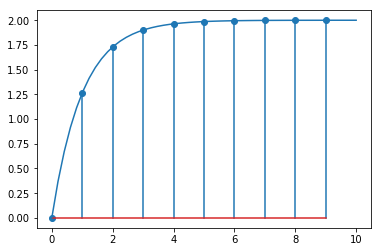

In [26]:
plt.stem(sampledt, responses)
plt.plot(smootht, analytic_firstorder)

## Calculation using scipy

We can get the same values without going through the symbolic steps by using the `scipy.signal` library.

In [27]:
import scipy.signal

In [28]:
a1 = -numpy.exp(-Dt/tau)
b1 = K*(1 - numpy.exp(-Dt/tau))

In [29]:
scipy.signal.dlti?

Note this uses the transfer function in terms of $z$ (not $z^{-1}$).

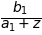

In [30]:
Gz.expand()

In [31]:
Gdiscrete = scipy.signal.dlti(b1, [1, a1], dt=1)

In [32]:
_, response = Gdiscrete.step(n=N)

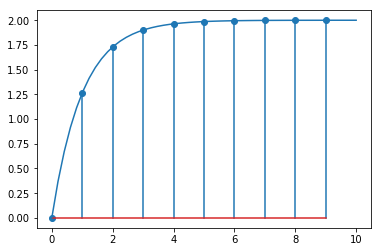

In [33]:
plt.stem(sampledt, numpy.squeeze(response))
plt.plot(smootht, analytic_firstorder)

## Calculation using the control libary

In [34]:
import control

In [35]:
G = control.tf(b1, [1, a1], 1)

In [36]:
G


  1.264
----------
z - 0.3679

dt = 1

In [37]:
sampledt, response = control.step_response(G)

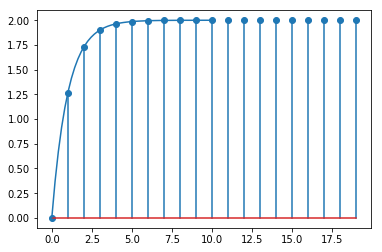

In [38]:
plt.stem(sampledt, numpy.squeeze(response))
plt.plot(smootht, analytic_firstorder)